Making a conservative model to simulate HST observations = Phoenix + Mg II

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interp1d
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.optimize import leastsq
from astropy.modeling import functional_models
from matplotlib.gridspec import GridSpec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [2]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/TRAPPIST-1/'
os.listdir(path)

['hlsp_muscles_multi_multi_trappist-1_broadband_v10_adapt-const-res-sed.fits',
 'hlsp_muscles_hst_cos_trappist-1_g130m_v10_component-spec.fits',
 'hlsp_muscles_hst_cos_trappist-1_g160m_v10_component-spec.fits',
 'hlsp_muscles_hst_cos_trappist-1_g230l_v10_component-spec.fits',
 'hlsp_muscles_hst_stis_trappist-1_g140m_v10_component-spec.fits',
 'hlsp_muscles_hst_stis_trappist-1_g430l_v10_component-spec.fits',
 'hlsp_muscles_model_apec_trappist-1_na_v10_component-spec.fits',
 'hlsp_muscles_model_dem_trappist-1_na_v10_component-spec.fits',
 'hlsp_muscles_model_lya-reconstruction_trappist-1_na_v10_component-spec.fits',
 'hlsp_muscles_model_phx_trappist-1_na_v10_component-spec.fits',
 'hlsp_muscles_multi_multi_trappist-1_broadband_v10_adapt-var-res-sed.fits',
 'hlsp_muscles_multi_multi_trappist-1_broadband_v10_const-res-sed.fits',
 'hlsp_muscles_multi_multi_trappist-1_broadband_v10_var-res-sed.fits',
 'hlsp_muscles_xmm_epic_trappist-1_na_v10_component-spec.fits']

In [3]:
phx = fits.getdata('{}hlsp_muscles_model_phx_trappist-1_na_v10_component-spec.fits'.format(path), 1)
normfac = fits.getheader('{}hlsp_muscles_model_phx_trappist-1_na_v10_component-spec.fits'.format(path), 0)['NORMFAC']

In [4]:
wp, fp = phx['WAVELENGTH'], phx['FLUX']*normfac
mask = (wp > 1950) & (wp <3700)
wp, fp = wp[mask], fp[mask]

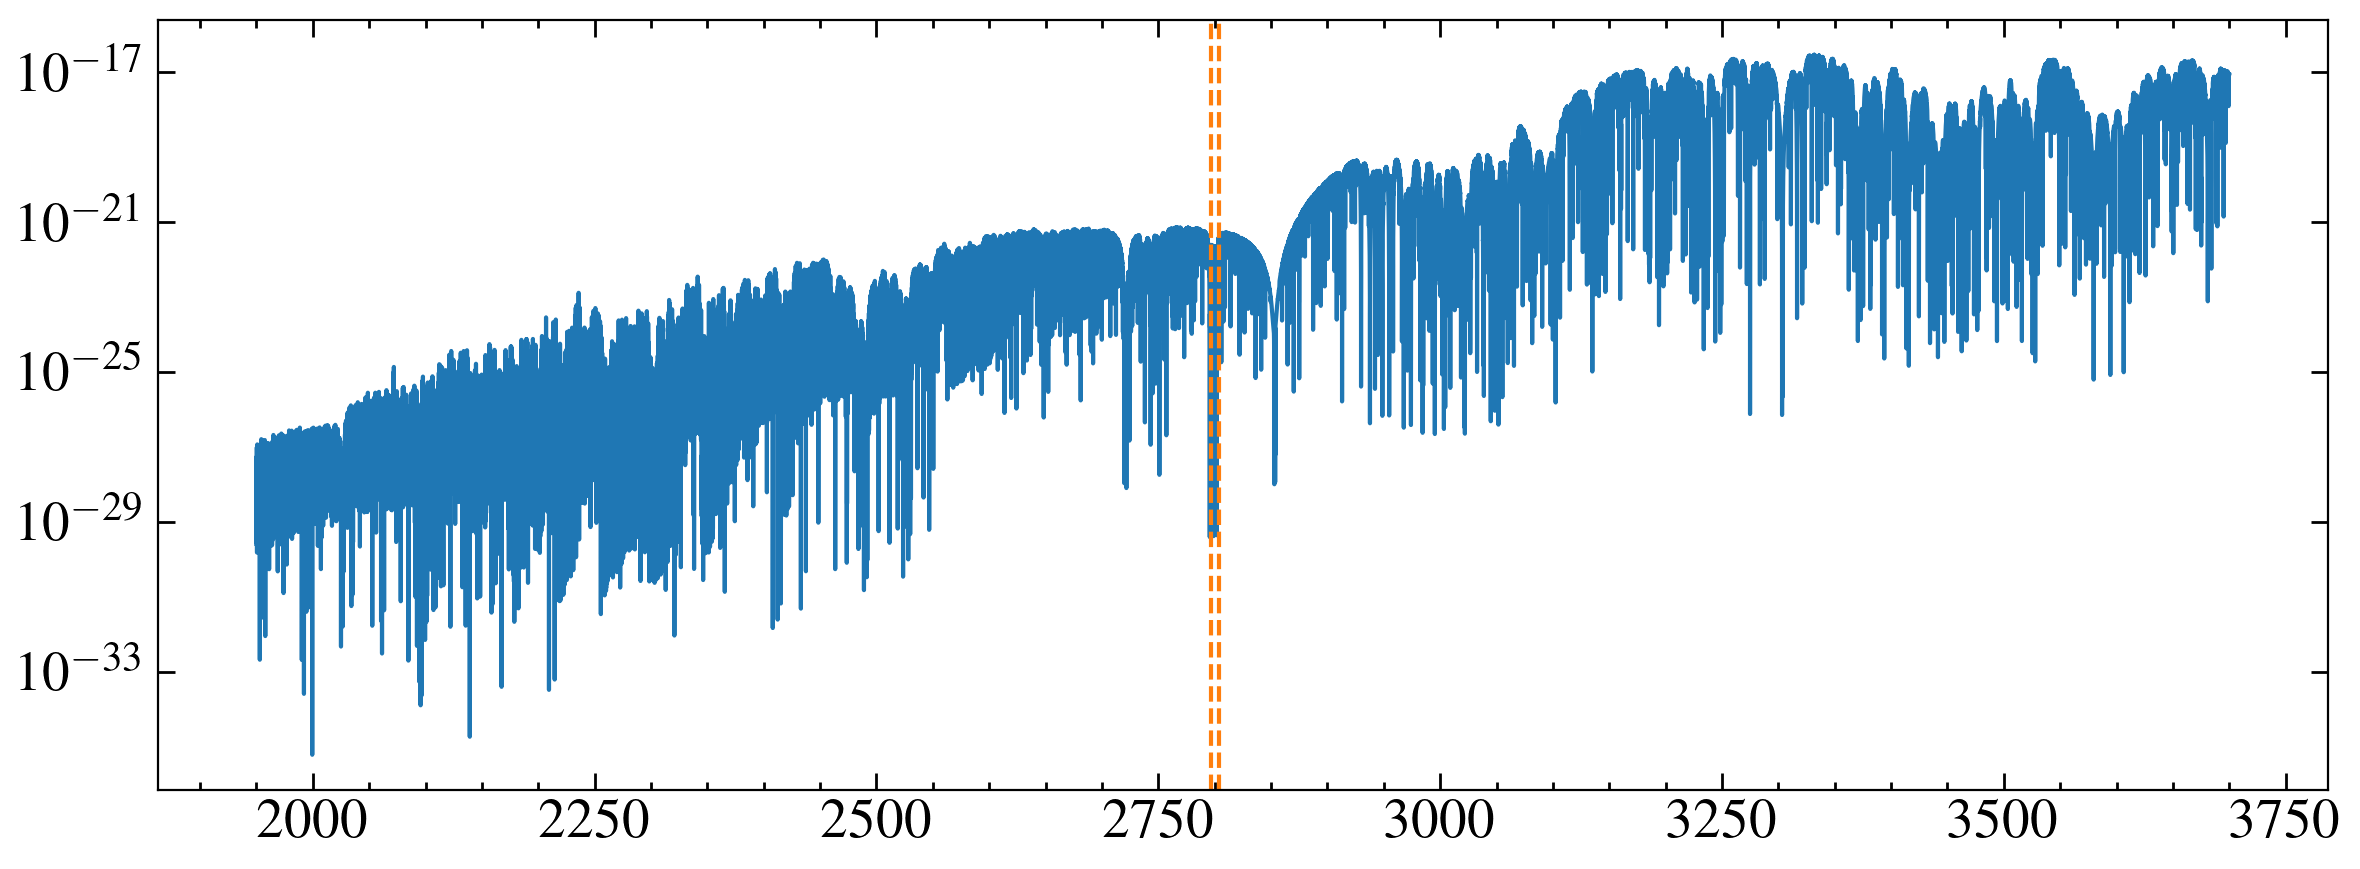

In [5]:
plt.plot(wp, fp)
plt.yscale('log')
# mg2 = [2795.523, 2802.697]

mg2 = [2796.352, 2803.53]

[plt.axvline(line, ls='--', c='C1') for line in mg2]

In [6]:
nuv = fits.getdata('{}hlsp_muscles_hst_cos_trappist-1_g230l_v10_component-spec.fits'.format(path), 1)

In [7]:
wn, fn, en = nuv['WAVELENGTH'], nuv['FLUX'], nuv['ERROR']
mask = (wn > 2750) & (wn < 2850)
wn, fn, en = wn[mask], fn[mask], en[mask]

[1.17008439e-17 1.51282781e-16 1.32622756e-01 1.25248046e-01
 2.87735754e-01]
1.1658896843618405e-15


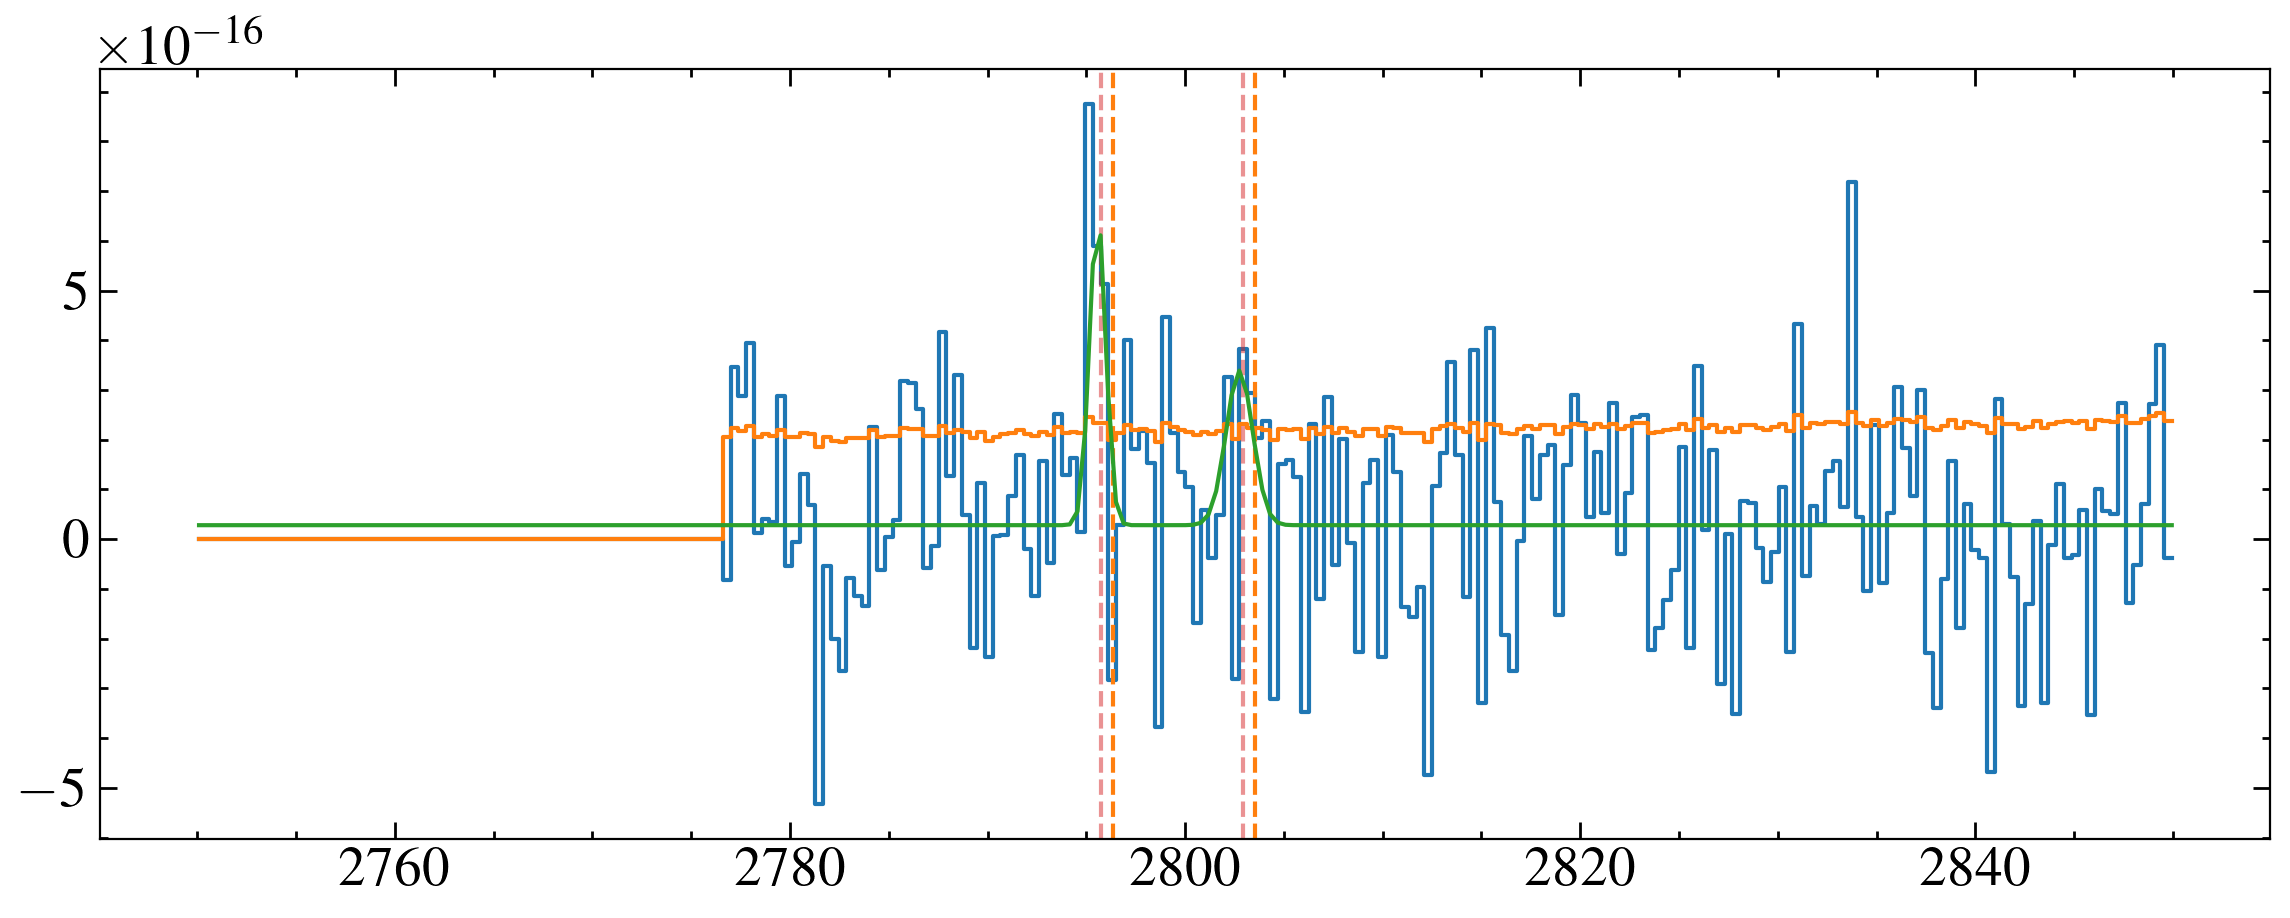

In [13]:
fitter = fitting.LevMarLSQFitter()

mg2 = [2796.352, 2803.53]
os = [6.08e-01, 3.03e-01]

plt.step(wn, fn)
plt.step(wn, en)
# plt.plot(wp, fp)
# plt.yscale('log')
[plt.axvline(line, ls='--', c='C1') for line in mg2]

lines = np.copy(mg2)

mod = models.Const1D(0)#, fixed=dict(amplitude=True))
for line in lines:
    line_guess = (-63*u.km/u.s).to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
    mod = mod+  models.Gaussian1D(amplitude=np.max(fn)/2, mean = line_guess, stddev=1)
    # mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fn), fwhm_G=1, fwhm_L=1, bounds=dict(amplitude_L=[0, 1]))
    # plt.axvline(line, ls='--', c='C2', alpha =0.5)
    plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)

def tiedfunc0(mod):
    mean = mod.mean_1.value+np.diff(lines)
    return mean


def tiedfunc1(mod):
    x_0 = mod.x_0_1.value+np.diff(lines)
    # fwhm_G = mod.fwhm_G_1.value
    return x_0

def tiedfwhmg(mod):
    fwhm_G = mod.fwhm_G_1.value
    return fwhm_G

def tiedfwhml(mod):
    fwhm_L = mod.fwhm_L_1.value
    return fwhm_L

# def tiedamp(mod):
#     amplitude_L = mod.amplitude_L_1.value/(os[0]/os[1])
#     return amplitude_L

def tiedamp(mod):
    amplitude = mod.amplitude_1.value/(os[0]/os[1])
    return amplitude

mod.mean_2.tied=tiedfunc0
# mod.x_0_2.tied=tiedfunc1
# mod.fwhm_G_2.tied=tiedfwhmg
# mod.fwhm_L_2.tied=tiedfwhml
mod.amplitude_2.tied = tiedamp

gg_fit = fitter(mod, wn, fn, maxiter=100000)

# print(gg_fit)


if type(fitter.fit_info['param_cov']) == np.ndarray:
#     print('hooray!')
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    print(fit_e)
    
plt.plot(wn, gg_fit(wn))
gg_fit

print(np.trapz(gg_fit(wn), wn) - np.trapz(gg_fit[0](wn), wn))

(2240.0, 3260.0)

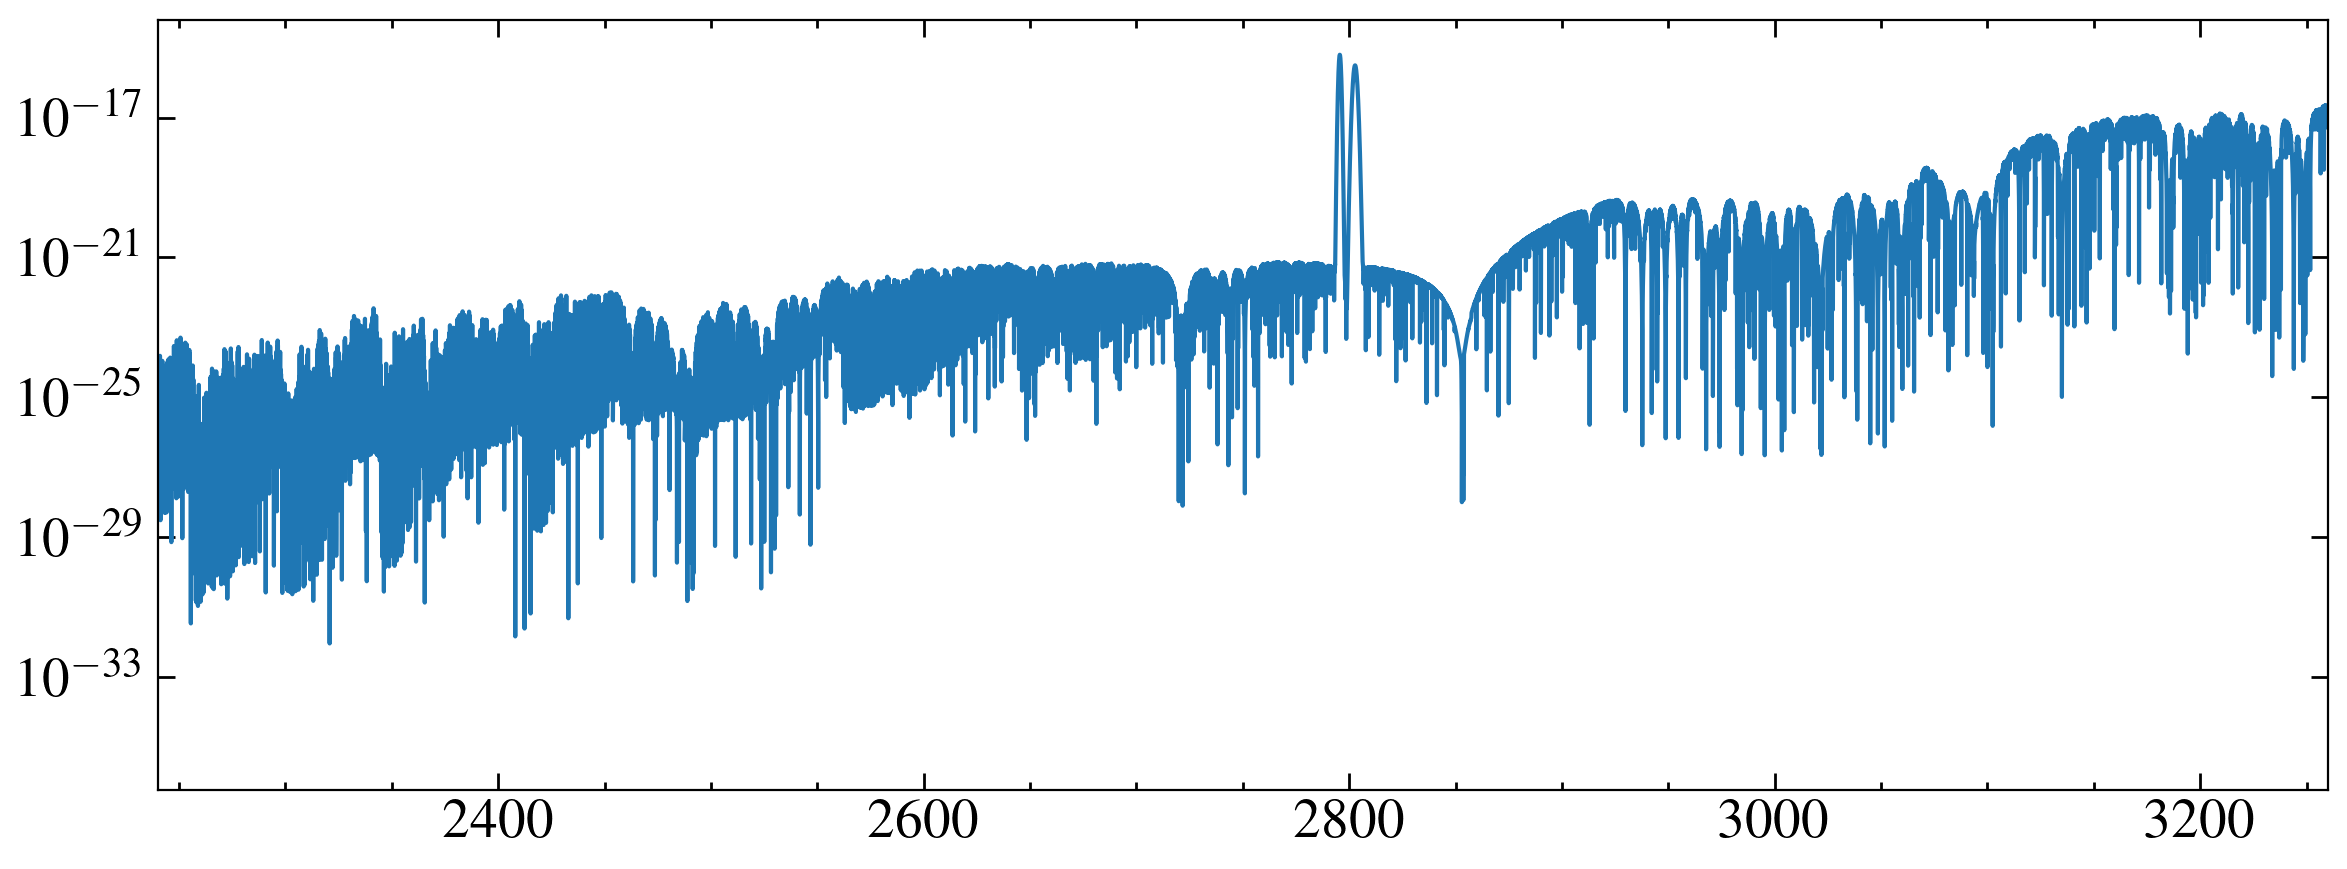

In [9]:
wm = wp
fl = gg_fit(wm) - gg_fit[0](wm) #lines - contfit
fm = fp + fl 
plt.plot(wm, fm)
# plt.plot(wm, gg_fit(wm))
plt.yscale('log')
# plt.xscale('log')
plt.xlim(2240, 3260)

# semp = Table.read('../paper/saved_models/trappist-1_model_var_res_v07.ecsv')
# plt.plot(semp['WAVELENGTH'], semp['FLUX'])


In [10]:
from svo_filters import svo

ModuleNotFoundError: No module named 'svo_filters'

In [ ]:
filters =  ['WFC3_UVIS1.F280N', 'WFC3_UVIS1.F225W', 'WFC3_UVIS1.F275W']

plt.plot(wm, fm)

for flt in filters:
    bp =  svo.Filter(flt)
    bpw, bpf = bp.wave[0]*10000, (bp.throughput[0]/6e13)
    #print(bp.name)
    plt.plot(bpw, bpf, lw=2, ls='--', label = r'{}'.format(bp.name.replace('_', ' ')))
plt.yscale('log')

wm5, fm5 = np.loadtxt('scaled_M5_uv.dat', unpack=True)
plt.plot(wm5, fm5)

In [ ]:
savdat = Table([wm, fm], names=['#WAVELENGTH', 'FLUX'])
ascii.write(savdat, 't1uv_model_v2.dat', format='basic', overwrite=True)

Put model into the ETC  

https://etc.stsci.edu/etc/results/WFC3UVIS.im.1722296/ F280N 971s for S/N = 10, optimum S/N = 17  
https://etc.stsci.edu/etc/results/WFC3UVIS.im.1722299/ F280N 1800s for S/N = 15, optimum S/N = 24

https://etc.stsci.edu/etc/results/WFC3UVIS.im.1722300/ F275W 753s for S/N = 10, optimum S/N = 17

I think we do this in one orbit?

https://etc.stsci.edu/etc/results/WFC3UVIS.im.1722301/ F225W 30,752s! for S/N = 10  
https://etc.stsci.edu/etc/results/WFC3UVIS.im.1722303/ F225W 1800s for S/N = 1.7, optimum S/N = 4 

Get 1-2 orbits of F225W to at least get a limit.  

What S/N do we need to distingush F280N from F275N?


In [ ]:
def make_phot(bp_w, bp_cc, w, f):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    return np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)

In [ ]:
filters =  ['WFC3_UVIS1.F280N', 'WFC3_UVIS1.F275W']

phot_predict = []

for flt in filters:
    bp =  svo.Filter(flt)
    bpw, bpf = bp.wave[0].value*10000, bp.throughput[0]
    # print(bpw[0], bpw[-1])
    # print(wm[0], wm[-1])
    phot = make_phot(bpw, bpf, wm, fm)
    phot_predict.append(phot)
print(phot_predict)
print(phot_predict[0]/phot_predict[1])

phot_predict=np.array(phot_predict)
plt.figure(figsize=(4,4))
plt.errorbar([0,1], phot_predict, yerr=phot_predict*0.1)

In [ ]:
f_mg = np.trapz(fm[(wm > 2780) & (wm < 2810)], wm[(wm > 2780) & (wm < 2810)])
f_c = np.trapz(fm[(wm > 2500) & (wm < 3000)], wm[(wm > 2500) & (wm < 3000)])
print(f_mg, f_c)
print(f_mg/f_c)

#hmm

So we may not be able to distingish the two if the contiumum is low.